# load imports

In [54]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [55]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [56]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
directory='PlantVillage',
seed=123,
shuffle = True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [57]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [58]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (32, 255, 255, 3)
Single Image :  tf.Tensor(
[[[141.98236  115.98237  116.98237 ]
  [136.82382  110.823814 111.823814]
  [107.35246   81.35246   82.35246 ]
  ...
  [173.01381  155.01381  151.01381 ]
  [181.93741  163.93741  159.93741 ]
  [195.95111  177.95111  173.95111 ]]

 [[137.87445  111.87446  112.87446 ]
  [136.8248   110.82481  111.82481 ]
  [132.12982  106.129814 107.129814]
  ...
  [175.0646   157.0646   153.0646  ]
  [176.98244  158.98244  154.98244 ]
  [184.96088  166.96088  162.96088 ]]

 [[117.12743   91.12743   92.12743 ]
  [112.31633   86.31633   87.31633 ]
  [144.35968  118.35967  119.35967 ]
  ...
  [176.0387   158.0387   154.0387  ]
  [176.02917  158.02917  154.02917 ]
  [181.049    163.049    159.049   ]]

 ...

 [[107.330246  81.330246  80.330246]
  [145.66852  119.6685   118.6685  ]
  [126.09693  100.09693   99.09693 ]
  ...
  [162.9805   142.9805   141.9805  ]
  [166.96677  146.96677  145.96677 ]
  [170.96283  150.96283  149.96283 ]]

 [[114.9

In [59]:
len(class_names)

3

# Visualize some of the images from our dataset

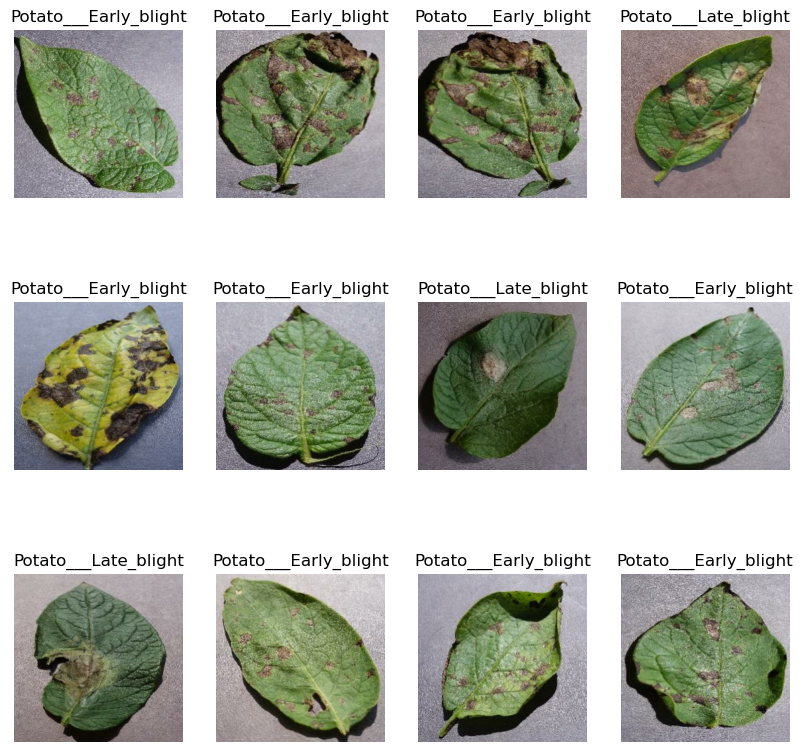

In [60]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training                                                       
Validation: Dataset to be tested against while training                                                      
Test: Dataset to be tested against after we trained a model                                        

In [61]:
len(dataset)

68

In [62]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [63]:
train_ds = dataset.take(54)
len(train_ds)

54

In [64]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [65]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [66]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [67]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [68]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [69]:
len(train_ds)

54

In [70]:
len(val_ds)

6

In [71]:
len(test_ds)

8

# Cache, Shuffle, and Prefetch the Dataset


In [72]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model


In [73]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Data Augmentation


In [74]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset

In [75]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [76]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [77]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [78]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [79]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 630ms/step - accuracy: 0.4891 - loss: 0.9243 - val_accuracy: 0.7240 - val_loss: 0.6549
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 630ms/step - accuracy: 0.7272 - loss: 0.6102 - val_accuracy: 0.7240 - val_loss: 0.6130
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.8274 - loss: 0.3927 - val_accuracy: 0.8646 - val_loss: 0.2719
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 620ms/step - accuracy: 0.8811 - loss: 0.2631 - val_accuracy: 0.8490 - val_loss: 0.3364
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 645ms/step - accuracy: 0.9230 - loss: 0.2010 - val_accuracy: 0.8438 - val_loss: 0.3275
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9242 - loss: 0.2043 - val_accuracy: 0.9010 - val_loss: 0.2567
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9360 - loss: 0.1989 - val_accuracy: 0.9323 - val_loss: 0.1723
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 990ms/step - accuracy: 0.9530 - loss: 0.1341 - val_accuracy: 

In [80]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9579 - loss: 0.1025


In [90]:
model.save('model.keras')


# Plotting the Accuracy and Loss Curves

In [82]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 20, 'steps': 54}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [83]:
history.history['loss'] # show loss for first 5 epochs

[0.8640468120574951,
 0.5081379413604736,
 0.3558981716632843,
 0.23648077249526978,
 0.21945427358150482,
 0.2286626696586609,
 0.2054392695426941,
 0.1515992134809494,
 0.15551051497459412,
 0.1319091022014618,
 0.1588965803384781,
 0.12813732028007507,
 0.1184535026550293]

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

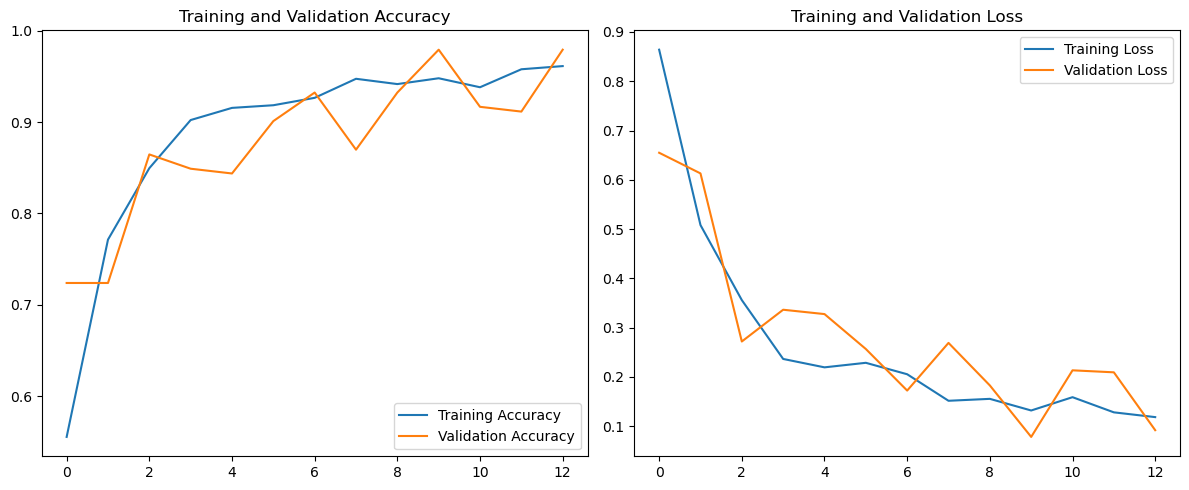

In [85]:
# Plotting
import matplotlib.pyplot as plt

epochs_ran = len(acc)
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs_ran), acc, label='Training Accuracy')
plt.plot(range(epochs_ran), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs_ran), loss, label='Training Loss')
plt.plot(range(epochs_ran), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Run prediction on a sample image

In [91]:
model = tf.keras.models.load_model('model.keras')

C:\Users\VINAMRATA CHHONKAR\New folder\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
predicted label: Potato___Late_blight


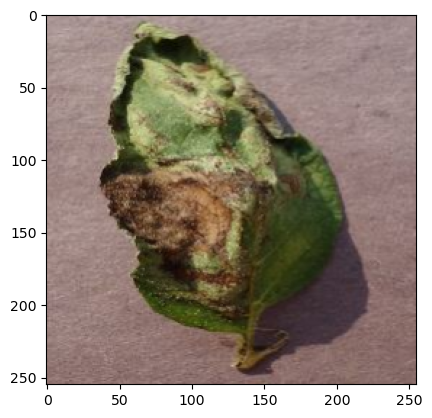

In [92]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [93]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


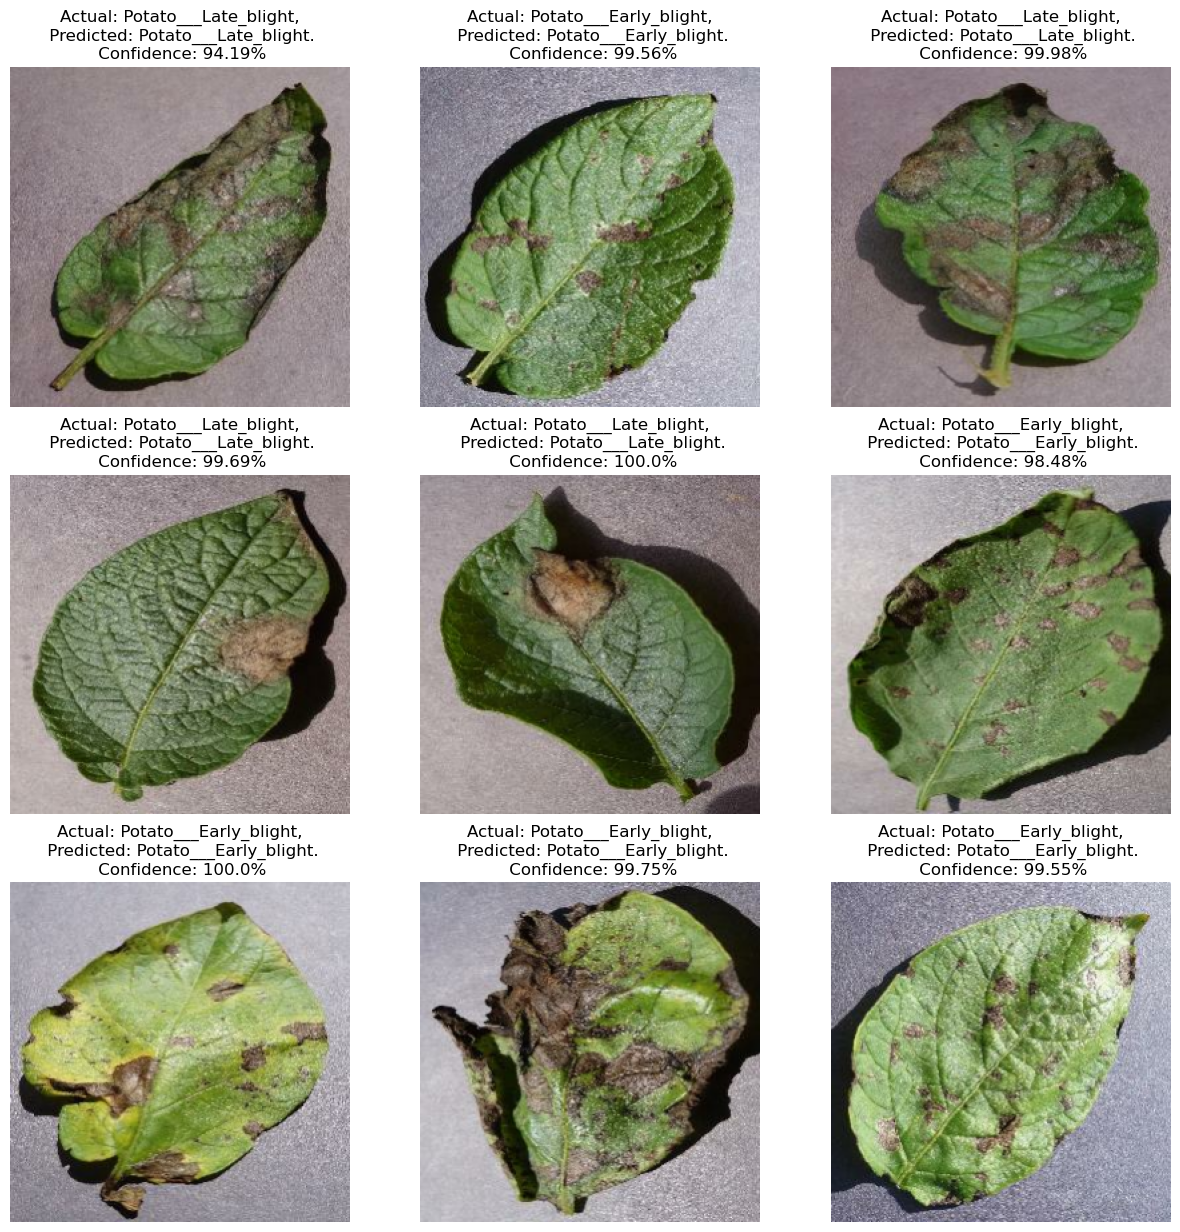

In [94]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")